# **1. Veri Setini Yükleme ve Genel Yapısını İnceleme**

### 1.1. Kütüphaneleri Yükleme

In [ ]:
# Veri işleme ve sayısal işlemler için kütüphaneler
import pandas as pd
import numpy as np
# Görselleştirme kütüphaneleri
import seaborn as sns
import matplotlib.pyplot as plt
# İstatistiksel analiz
from scipy.stats import skew
# Veri ön işleme
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
# Modelleme için Metrikler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
# Model değerlendirme metrikleri
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
import warnings # warningleri kapatma
warnings.filterwarnings("ignore")

### 1.2. Veri Setini Yükleme

In [ ]:
np.random.seed(42)
n = 120

df = pd.DataFrame({
    "age": np.random.randint(18, 65, size=n),
    "gender": np.random.choice(["Male", "Female"], size=n),
    "monthly_income": np.random.normal(8000, 2500, size=n),
    "city": np.random.choice(["İstanbul", "Ankara", "İzmir"], size=n),
    "purchase_score": np.random.randint(1, 100, size=n),
})

# eksik değerler ekle
df.loc[np.random.choice(n, 10, replace=False), "monthly_income"] = np.nan
df.loc[np.random.choice(n, 8, replace=False), "city"] = np.nan

# anlamlı target: harcama miktarı
df["spending"] = df["monthly_income"] * 0.8 + df["age"] * 30 + np.random.normal(0, 700, size=n)

# aykırı değer
df.loc[3, "spending"] = 60000
df.loc[10, "monthly_income"] = 50000

### 1.3. Veri Setinin Genel Yapısını İnceleme

In [ ]:
df.head() #veri setinin ilk 5 satırı

,age,gender,monthly_income,city,purchase_score,spending
0,56,Female,7839.054873,İstanbul,34,9102.721298
1,46,Female,8862.255838,İstanbul,7,8295.479442
2,32,Male,7799.781662,İstanbul,68,7603.415203
3,60,Male,NaN,İstanbul,58,60000.000000
4,25,Female,11583.788718,İzmir,75,12172.247540


In [ ]:
df.tail() #veri setinin son 5 satırı

,age,gender,monthly_income,city,purchase_score,spending
115,25,Female,11003.451111,İstanbul,67,8953.502210
116,29,Male,8374.584291,Ankara,45,7619.763799
117,51,Male,8352.268420,Ankara,13,7877.454523
118,50,Male,8886.048963,Ankara,92,8944.125048
119,40,Male,3299.218529,Ankara,58,4072.938297


In [ ]:
df.shape #veri setinin satır-sütun sayısı

(120, 6)

In [ ]:
df.info() #Veri setinin genel bilgilerini, sütun tiplerini ve eksik değer durumunu anlama

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             120 non-null    int64  
 1   gender          120 non-null    object 
 2   monthly_income  110 non-null    float64
 3   city            112 non-null    object 
 4   purchase_score  120 non-null    int64  
 5   spending        111 non-null    float64
dtypes: float64(2), int64(2), object(2)
memory usage: 5.8+ KB


In [ ]:
df.describe() # Sayısal sütunların temel istatistiksel özetini (ortalama, std, min, max vb.) inceleme

,age,monthly_income,purchase_score,spending
count,120.000000,110.000000,120.000000,111.000000
mean,40.666667,8373.833079,48.991667,8024.503392
std,13.820782,4779.167000,28.883858,5497.864840
min,18.000000,801.357766,4.000000,2281.114419
25%,28.000000,6316.750671,23.000000,6075.911356
50%,41.000000,8179.744257,47.500000,7619.763799
75%,53.000000,10048.871788,74.000000,9130.925378
max,64.000000,50000.000000,99.000000,60000.000000


# **2.  Verilen Görevler**

## **2.1. Eksik Değer Analizi**

### 2.1.1. Eksik Veri Olan Sütunlar

In [ ]:
df.isnull().sum() #eksik olan sütunları inceleme

,0
age,0
gender,0
monthly_income,10
city,8
purchase_score,0
spending,9


monthly_income sütununda 10, city sütununda 8, spending sütununda 9 eksik değerimiz olduğunu görüyoruz..

### 2.1.2. Her Bir Sütun İçin Eksik Oran

In [ ]:
# Her sütun için eksik veri oranı (satır sayısına göre)
missing_ratio = df.isnull().sum() / len(df)

# Yalnızca eksik verisi olan sütunlar
missing_ratio = missing_ratio[missing_ratio > 0]

print(missing_ratio.sort_values(ascending=False))


monthly_income    0.083333
spending          0.075000
city              0.066667
dtype: float64


Çıktımıza göre sadece 3 sütunumuzda eksik değerlerimiz var bu oranlar şu şekildedir:

*   monthly_income -->	8.33%
*   spending	--> 7.50%
* city -->	6.67%



## **2.2. Eksik Verilerin Tamamlanması**

### 2.2.1. Sayısal Değişkenleri SimpleImputer ile Doldurma

Median - mean için kullanımlar:
* Veri simetrik (normal dağılıma yakın)	--> mean
* Veri sağa/sola çarpık (skewed) --> median

### 📈 Skewness Değerine Göre Dağılım Yorumları

| Skewness Değeri | Yorum        |
|------------------|--------------|
| > 0              | Sağ çarpık   |
| < 0              | Sol çarpık   |
| ≈ 0              | Simetrik     |


In [ ]:
print("Çarpıklık:", df['monthly_income'].skew()) #çarpıklık inceleme

Çarpıklık: 6.06084898058888


Buradan çıkan sonuçla görüyoruz ki verimiz sağa çarpık. Bu nedenle eksik değerlerimizi median ile dolduracağız..

In [ ]:
# SimpleImputer ile ortalama doldurma
imp_mean = SimpleImputer(strategy="median")
df[['monthly_income', 'spending']] = imp_mean.fit_transform(df[['monthly_income', 'spending']])


Median ile eksik değerlerimi dolduruyorum..

In [ ]:
df.isnull().sum()

,0
age,0
gender,0
monthly_income,0
city,8
purchase_score,0
spending,0


Görüldüğü üzere sayısal değişkenlerde yer alan eksik değerler kaldırıldı.

### 2.2.2. Kategorik Değişkenleri En Sık Kategori ile Doldurma

In [ ]:
# Kategorik sütun - En sık değerle doldurma
df['city'] = df['city'].fillna(df['city'].mode()[0])

En sık değerler doldurma işlemimiz de mode kullanıyoruz..

---


Mode, bir sayı kümesinde en sık görülen değer için kullanılan istatistiksel bir terimdir.

In [ ]:
df.isnull().sum()

,0
age,0
gender,0
monthly_income,0
city,0
purchase_score,0
spending,0


Görüldüğü üzere kategorik değişkenimizde yer alan eksik değerler de kaldırıldı.

 ## **2.3.  Aykırı Değer Analizi**

### 2.3.1. spending ve monthly_income Değişkenleri İçin Boxplot Çizme

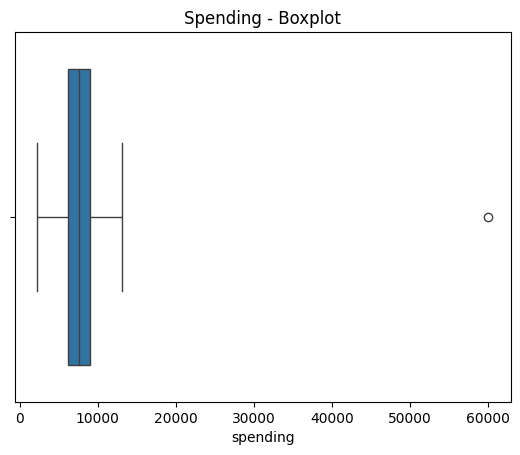

In [ ]:
sns.boxplot(x=df["spending"]) # 'spending' sütununun dağılımını ve aykırı değerleri kutu grafiği ile gösterme
plt.title("Spending - Boxplot")
plt.show()

Bu boxplot’a göre, spending değişkeninin çoğunlukla yaklaşık 2000 ile 14000 arasında dağıldığını söylebiliriz. Ancak, 60000 gibi çok yüksek bir değer, diğerlerinden oldukça farklı ve bu nedenle aykırı değer (outlier) olarak değerlendirilebilir.

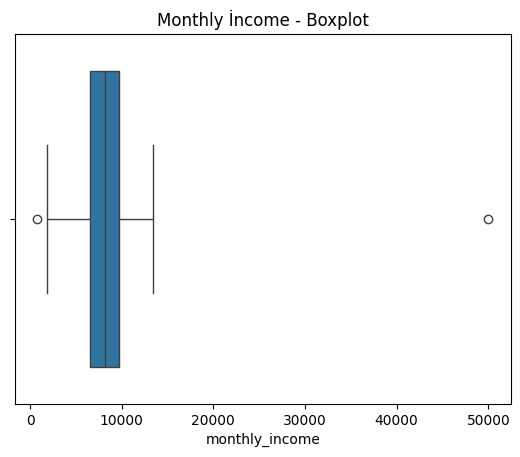

In [ ]:
sns.boxplot(x=df["monthly_income"]) # 'monthly_income' sütununun dağılımını ve aykırı değerleri kutu grafiği ile gösterme
plt.title("Monthly İncome - Boxplot")
plt.show()


Bu boxplot’a göre, spending değişkeninin çoğunlukla yaklaşık 2000 ile 14000 arasında dağıldığını söylebiliriz. Ancak, 50000 gibi çok yüksek bir değer ve 0'a yakın daha küçük bir değer diğerlerinden oldukça farklı ve bu nedenle aykırı değer (outlier) olarak değerlendirilebilir. Bu tür aykırı değerler, analiz ve modelleme süreçlerinde dikkatle ele alınmalıdır.

### 2.3.2. IQR Yöntemine Göre Aykırı Değerleri Tespit Etme

In [ ]:
# Sadece sayısal veri tipine sahip sütunları seçiyoruz
numeric_cols = df.select_dtypes(include='number').columns

# Her bir sayısal sütun için döngü başlatıyoruz
for col in numeric_cols:

    # 1. çeyrek değer (Q1): Verinin %25'i bu değerin altında
    Q1 = df[col].quantile(0.25)

    # 3. çeyrek değer (Q3): Verinin %75'i bu değerin altında
    Q3 = df[col].quantile(0.75)

    # IQR (Interquartile Range): Q3 - Q1 → orta %50'lik aralık
    IQR = Q3 - Q1

    # Aykırı değer alt sınırı: Q1 - 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR

    # Aykırı değer üst sınırı: Q3 + 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Aykırı değerleri filtreleme: alt sınırdan küçük veya üst sınırdan büyük olanlar
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

    # Eğer aykırı değer varsa (outliers boş değilse)
    if not outliers.empty:
        # Hangi sütunda aykırı değer bulunduğunu yazdır
        print(f"\n - Aykırı değerler - {col} sütunu:")

        # Sadece o sütundaki aykırı değerleri yazdır
        print(outliers[[col]])




 - Aykırı değerler - monthly_income sütunu:
    monthly_income
10    50000.000000
56      801.357766

 - Aykırı değerler - spending sütunu:
   spending
3   60000.0


Aykırı Değer Analizi (IQR Yöntemi ile):

* monthly_income sütununda, 50.000 ve 800 gibi uç değerler aykırı olarak tespit edilmiştir. Bu değerler, genel gelir dağılımının dışında kaldığı için veri setinin geri kalanından farklı davranabilir.

* spending sütununda ise 60.000 değeri, diğer harcama değerlerine göre oldukça yüksek olup aykırı değer olarak belirlenmiştir.

Bu değerler, boxplot ile yaptığımız aykırı değer tespitini sayısal olarak da doğrulamıştır. Böylece hem görsel hem de istatistiksel yöntemlerle aykırı değerlerin varlığı teyit edilmiştir.

Bu aykırı değerlerin varlığı, model performansını ve analiz sonuçlarını etkileyebilir; bu yüzden veri temizliği veya dönüştürme adımlarında dikkatle ele alınmalıdır.

 ## **2.4.  Aykırı Değer İşleme**

### 2.4.1. Winsorizing Yöntemiyle Aykırı Değerleri Baskılama

In [ ]:
df["spending_winsorized"] = df["spending"].clip(lower=lower_bound, upper=upper_bound)
# 'spending' sütunundaki aykırı değerleri Winsorizing yöntemi ile alt ve üst sınırlar arasında sınırlandırarak yeni bir sütun oluşturuyoruz..

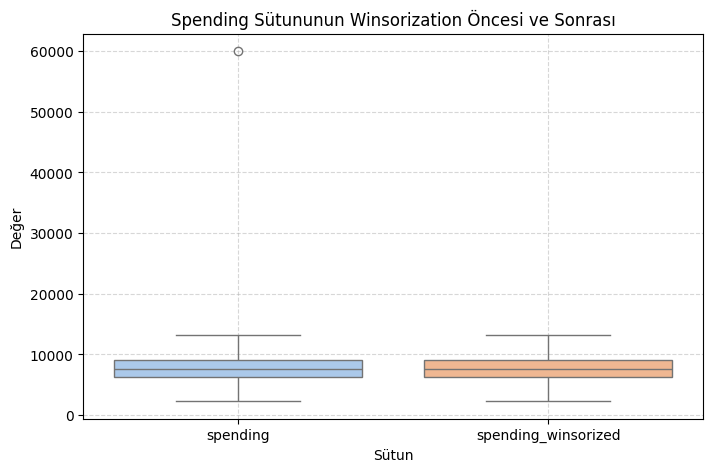

In [ ]:
plt.figure(figsize=(8, 5))

# 'spending' ve 'spending_winsorized' sütunlarını eriterek (melt) uzun formata çeviriyoruz
# Ve bu verilerle boxplot çiziyoruz, böylece Winsorization öncesi ve sonrası karşılaştırılıyor..

sns.boxplot(x="variable", y="value", data=pd.melt(df[["spending", "spending_winsorized"]]), palette="pastel")

plt.title("Spending Sütununun Winsorization Öncesi ve Sonrası")
plt.xlabel("Sütun")
plt.ylabel("Değer")
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()


Bu boxplot grafiğinde, spending sütununun Winsorizing işlemi öncesi ve sonrasındaki dağılımını karşılaştırdık. Winsorizing yöntemi, aykırı değerleri belirlenen alt ve üst sınırlarla sınırlandırarak aşırı uçların etkisini azaltır.
Grafikte görüldüğü üzere, orijinal spending sütununda belirgin aykırı değerler (özellikle üst uçta) mevcuttu. Ancak Winsorizing sonrası spending_winsorized sütununda bu aşırı uç değerler sınırlandırıldığı için grafikte ortadan kalkmış veya belirgin biçimde azalmıştır.
Bu durum, veri setindeki aykırı değerlerin modelleme ve analiz üzerindeki etkisini azaltmak için Winsorizing'in etkili bir yöntem olduğunu göstermektedir. Böylece, daha dengeli ve güvenilir bir veri dağılımı elde edilmiştir.

In [ ]:
df["monthly_income_winsorized"] = df["monthly_income"].clip(lower=lower_bound, upper=upper_bound)
# 'monthly_income' sütunundaki aykırı değerleri Winsorizing yöntemi ile alt ve üst sınırlar arasında sınırlandırarak yeni bir sütun oluşturuyoruz..

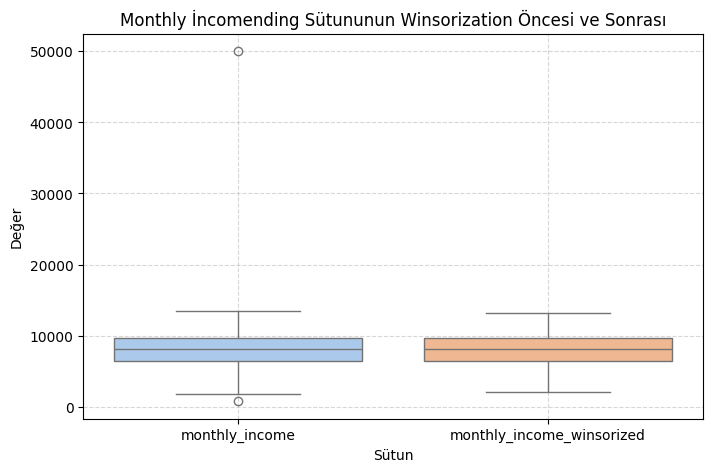

In [ ]:
plt.figure(figsize=(8, 5))

# 'monthly_income' ve 'monthly_income_winsorized' sütunlarını eriterek (melt) uzun formata çeviriyoruz
# Ve bu verilerle boxplot çiziyoruz, böylece Winsorization öncesi ve sonrası karşılaştırılıyor..

sns.boxplot(x="variable", y="value", data=pd.melt(df[["monthly_income", "monthly_income_winsorized"]]), palette="pastel")

plt.title("Monthly İncomending Sütununun Winsorization Öncesi ve Sonrası")
plt.xlabel("Sütun")
plt.ylabel("Değer")
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()


Benzer şekilde, monthly_income sütununda da Winsorizing uygulandıktan sonra alt ve üst uçlardaki aykırı değerler etkili bir şekilde sınırlandırılmıştır ve görselleştirmede bu uç değerlerin kaybolduğu görülmektedir.



 ## **2.5.  Kategorik Verileri Kodlama**

### 2.5.1. `gender`: LabelEncoder

In [ ]:
le = LabelEncoder()
df['gender_label'] = le.fit_transform(df['gender']) # 'gender' sütunundaki kategorik verileri sayısal etiketlere dönüştürerek 'gender_label' adlı yeni sütun oluşturuyoruz..

In [ ]:
df.head()

,age,gender,monthly_income,city,purchase_score,spending,spending_winsorized,monthly_income_winsorized,gender_label
0,56,Female,7839.054873,İstanbul,34,9102.721298,9102.721298,7839.054873,0
1,46,Female,8862.255838,İstanbul,7,8295.479442,8295.479442,8862.255838,0
2,32,Male,7799.781662,İstanbul,68,7603.415203,7603.415203,7799.781662,1
3,60,Male,8179.744257,İstanbul,58,60000.000000,13227.392455,8179.744257,1
4,25,Female,11583.788718,İzmir,75,12172.247540,12172.247540,11583.788718,0


Görüldüğü üzere, Label Encoder kullanarak gender sütunundaki kategorik değerleri sayısal değerlere dönüştürdük. Bu dönüşüm sonucunda female değeri 0, male değeri ise 1 olarak kodlanmıştır.

### 2.5.2. `city`: One-Hot Encoding

In [ ]:
df = pd.get_dummies(df, columns=['city'], drop_first=True) # 'city' sütunundaki kategorik değişkeni one-hot encoding yöntemiyle dönüştürüp
#ilk kategoriyi referans almak için drop_first=True ile birinci sütunu çıkarıyoruz..

In [ ]:
df.head()

,age,gender,monthly_income,purchase_score,spending,spending_winsorized,monthly_income_winsorized,gender_label,city_İstanbul,city_İzmir
0,56,Female,7839.054873,34,9102.721298,9102.721298,7839.054873,0,True,False
1,46,Female,8862.255838,7,8295.479442,8295.479442,8862.255838,0,True,False
2,32,Male,7799.781662,68,7603.415203,7603.415203,7799.781662,1,True,False
3,60,Male,8179.744257,58,60000.000000,13227.392455,8179.744257,1,True,False
4,25,Female,11583.788718,75,12172.247540,12172.247540,11583.788718,0,False,True


`city` sütununda bulunan kategorik şehir isimleri, one-hot encoding yöntemi ile sayısal sütunlara dönüştürdük. Bu işlem sonucunda, her şehir için ayrı bir sütun oluşturulmuş ve bu sütunlarda ilgili satırın o şehre ait olup olmadığına göre True (1) veya False (0) değerleri yer almıştır.

Örneğin;

`city_İstanbul` sütunu, satırdaki kişinin İstanbul’da yaşayıp yaşamadığını belirtir.

`city_İzmir` sütunu ise aynı şekilde İzmir için geçerlidir.

Bu sayede, modelimiz kategorik şehir bilgilerini sayısal formatta kullanabilir hale gelmiştir.

 ## **2.6.   Sayısal Değişkenleri Ölçekleme**

### 2.6.1. `StandardScaler` ile Ölçekleme

In [ ]:
# Sayısal sütunlar
df_numeric = df[[  "age",
    "monthly_income_winsorized",
    "spending_winsorized",
    "purchase_score"]].dropna()

# Eğitim/test ayrımı
X_train, X_test = train_test_split(df_numeric, test_size=0.2, random_state=42)

# StandardScaler
scaler_std = StandardScaler()
X_train_std = scaler_std.fit_transform(X_train)
X_test_std  = scaler_std.transform(X_test)


###**Sayısal Verilerin Ölçeklendirilmesi**
Veri setimizdeki sayısal sütunları ölçeklendirmek için aşağıdaki adımları gerçekleştirdik:

* Sayısal sütunların seçimi:
Aykırı değerlerden arındırılmış ve Winsorize edilmiş monthly_income_winsorized ve spending_winsorized sütunları ile age ve purchase_score sütunlarını seçtik. Eksik değerleri içeren satırlar çıkarıldı.

* Eğitim ve test verilerinin ayrılması:
Veri setini %80 eğitim, %20 test olacak şekilde rastgele böldük (random_state=42 ile tekrarlanabilirlik sağlandı).

* StandardScaler ile ölçeklendirme:
Eğitim verisine fit_transform, test verisine ise yalnızca transform uyguluyoruz. **Ölçekleme işlemi, mutlaka eğitim-test ayrımından sonra uygulanmalıdır.**

- - Eğitim verisine `fit_transform()` ile ölçekleyici parametreleri (ortalama, standart sapma vb.) öğrenilip uygulanırken,  
test verisine yalnızca `transform()` uygulanmalıdır.  
Bunun nedeni, test verisinin modelin hiç "görmediği" veri olması gerektiğidir.  
Eğer tüm veri setine `fit()` uygulanırsa, test verisinin istatistikleri modele sızar ve bu da model doğrulamasının güvenilirliğini azaltır.


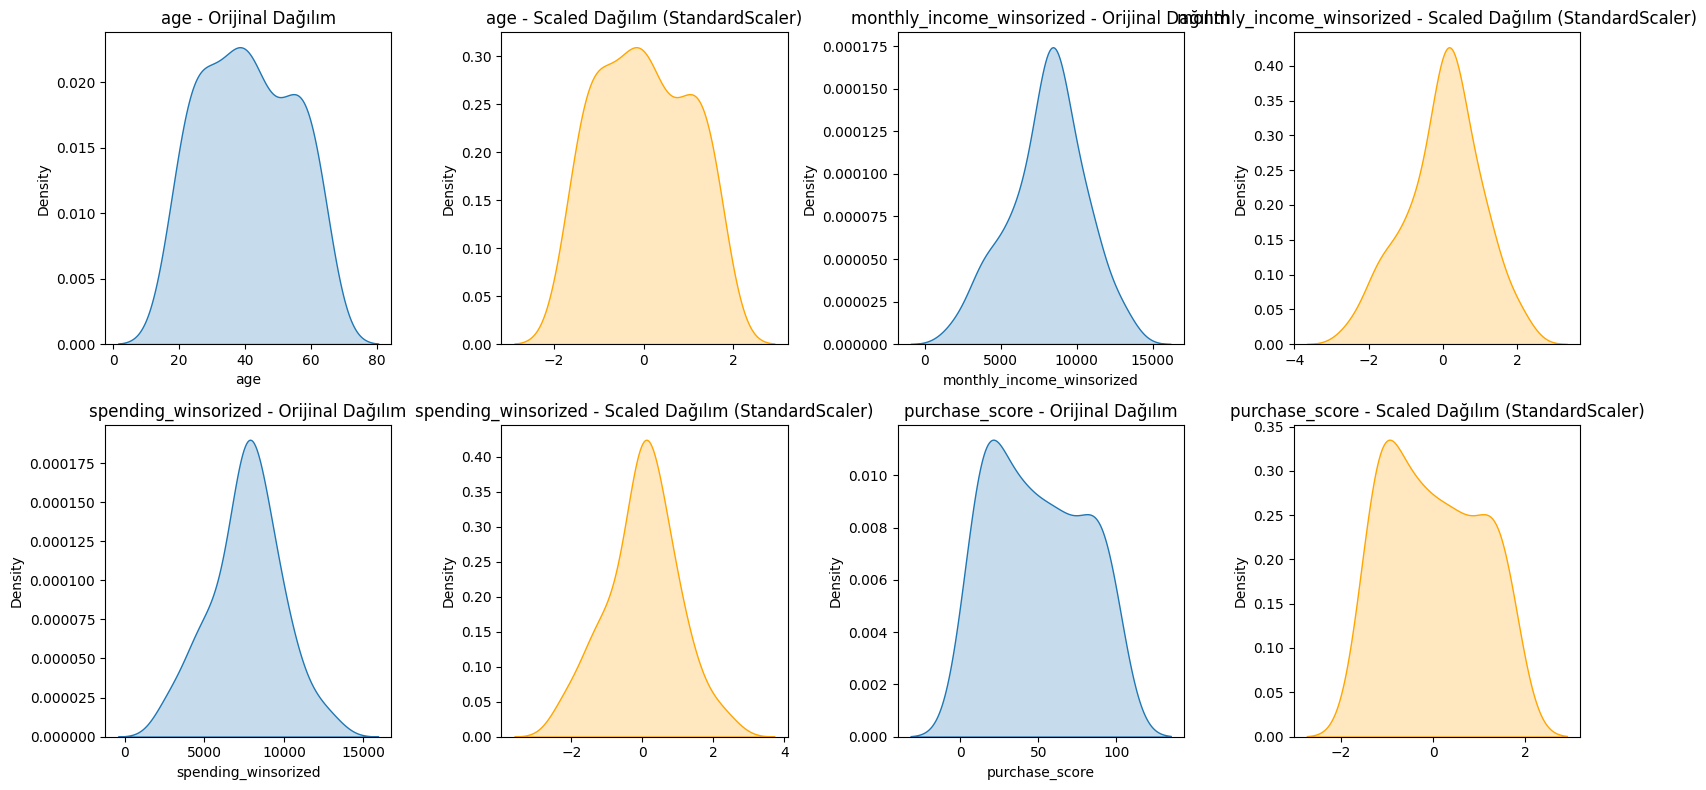

In [ ]:
plt.figure(figsize=(16, 8))

cols = ["age", "monthly_income_winsorized", "spending_winsorized", "purchase_score"]

for i, col in enumerate(cols):
    # Orijinal veri
    plt.subplot(2, 4, 2*i + 1)
    sns.kdeplot(X_train[col], label='Orijinal', fill=True)
    plt.title(f"{col} - Orijinal Dağılım")

    # Ölçeklenmiş veri
    plt.subplot(2, 4, 2*i + 2)
    sns.kdeplot(X_train_std[:, i], label='StandardScaler', fill=True, color="orange")
    plt.title(f"{col} - Scaled Dağılım (StandardScaler)")

plt.tight_layout()
plt.show()



Seçilen sayısal sütunların eğitim verisi üzerindeki dağılımlarını hem orijinal haliyle hem de StandardScaler ile ölçeklendirilmiş haliyle grafik üzerinden karşılaştırdık.

* Sol sütundaki grafikler her bir özelliğin orijinal dağılımını göstermektedir.

* Sağ sütundaki grafiklerde ise aynı özelliklerin StandardScaler uygulanmış dağılımları yer almaktadır.

 ## **2.7.   Log Dönüşüm Uygulama**

### 2.7.1. spending Değişkenine np.log1p() Uygulama ve Dağılımını Görselleştirme

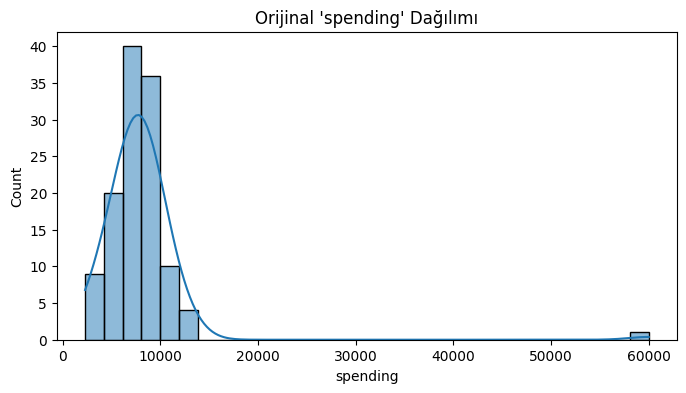

Orijinal çarpıklık (skewness): 7.98


In [ ]:
# Dağılım histogramı
plt.figure(figsize=(8, 4))
sns.histplot(df["spending"], bins=30, kde=True)
plt.title("Orijinal 'spending' Dağılımı")
plt.show()

# Çarpıklık değeri
original_skew = skew(df["spending"])
print(f"Orijinal çarpıklık (skewness): {original_skew:.2f}")

Grafikte spending sütununun orijinal dağılımı ve yoğunluk eğrisi gösterilmiştir. Çarpıklık (skewness) değeri 7.98 olup, dağılımın simetrik olmadığını, sağa doğru belirgin bir çarpıklık olduğunu göstermektedir.

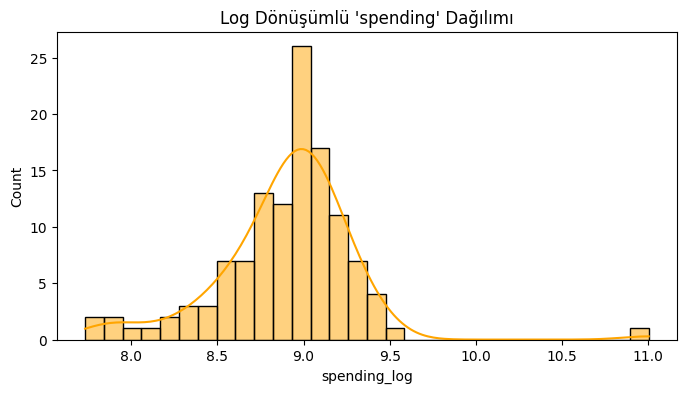

Log dönüşüm sonrası çarpıklık: 0.40


In [ ]:
df["spending_log"] = np.log1p(df["spending"])

# Dönüşümlü histogram
plt.figure(figsize=(8, 4))
sns.histplot(df["spending_log"], bins=30, kde=True, color="orange")
plt.title("Log Dönüşümlü 'spending' Dağılımı")
plt.show()

# Yeni çarpıklık değeri
log_skew = skew(df["spending_log"])
print(f"Log dönüşüm sonrası çarpıklık: {log_skew:.2f}")

Log dönüşümü ile sağa çarpık olan spending verisi daha simetrik hale getirilmeye çalışılmıştır. Yukarıdaki histogramda log dönüşümü sonrası dağılımın daha dengeli ve simetrik olduğu gözlemlenmektedir. Log dönüşümü uygulandıktan sonra, spending sütununun çarpıklık değeri 0.40 olarak ölçülmüş ve bu değer, verinin artık neredeyse simetrik olduğunu göstermektedir.

 ## **2.8.   Model Kurma**

### 2.8.1. Lineer Regresyon ile Modeli Kurma

In [ ]:
# 1. Bağımlı değişken
y = df["spending_log"]

# 2. Bağımsız değişkenler
X = df.drop(columns=["spending", "spending_log"])

# 3. Eğer kategorik varsa encode et
X = pd.get_dummies(X, drop_first=True)

# 4. Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Modeli eğit
model = LinearRegression()
model.fit(X_train, y_train)

# 7. Tahmin yap
y_pred = model.predict(X_test)

Log dönüşümlü spending hedef değişken olarak seçilmiş, kategorik değişkenler encode edilip veri eğitim ve test olarak ayrılmıştır. Daha sonra Lineer Regresyon modeli kullanılarak eğitim verisi üzerinde model eğitilmiş ve test verisi üzerinde tahmin yapılmıştır.

### 2.8.2. Modeli Değerlendirme (R², MSE)

In [ ]:
# Test verisiyle tahmin yap
y_pred = model.predict(X_test)

# R² skoru
r2 = r2_score(y_test, y_pred)

# Ortalama Kare Hata (MSE)
mse = mean_squared_error(y_test, y_pred)

print(f"R² Skoru: {r2:.4f}")
print(f"Ortalama Kare Hata (MSE): {mse:.4f}")

R² Skoru: -19.5713
Ortalama Kare Hata (MSE): 3.0029


Test verisi kullanılarak modelin tahminleri yapılmıştır. Ardından, modelin başarısını ölçmek için R² skoru ve Ortalama Kare Hata (MSE) hesaplanmıştır. Bu metrikler, modelin gerçek değerleri ne kadar iyi tahmin ettiğini gösterir.

 ## **2.9.   Modeli Değerlendirme**

### 2.9.1. R² Değeri Yorumlama

* R² Skoru (Determinasyon Katsayısı): Modelin hedef değişkendeki varyansın ne kadarını açıkladığını gösterir. 1’e yakınsa çok iyi, 0’a yakınsa kötü, negatifse model kötü demektir. Bizim modelimizde elimizde -19 gibi negatif skor bulunmaktadır bu da çok düşük performansı işaret ediyor.

* Ortalama Kare Hata (MSE): Tahminlerin gerçek değerlerden ortalama karesel farkını gösterir. Küçük olması daha iyi. Bizim modelimiz de Ortalama Kare Hata (MSE) ise 3.00 civarındadır; bu değer modelin tahminlerinde yüksek hata olduğunu ifade eder

### 2.9.2. Modelin Eksik Yönleri Neler Olabilir?

Mevcut modelimizin performansının düşük çıkmasının birkaç temel sebebi olabilir. Öncelikle, modelde kullanılan özelliklerin (feature) yetersiz veya eksik olması, yani feature engineering aşamasının yeterince derin yapılmaması önemli bir eksikliktir. Gerçek dünya verileri genellikle ham haliyle modellemeye doğrudan uygun olmaz. Bu yüzden, veriye yeni türev değişkenler eklemek, kategorileri daha anlamlı gruplara ayırmak veya etkileşimli değişkenler oluşturmak modelin doğruluğunu artırabilir.

Örneğin, ben bitirme projemde de müşteri verileri üzerinde çalışırken, sadece yaş, gelir gibi temel değişkenlerle değil; müşteri segmentasyonu, satın alma alışkanlıkları ve harcama oranları gibi türev özellikler geliştirerek modelin başarısını artırdım. Bu sayede model, kullanıcı davranışlarını daha iyi anlayıp, tahminlerde daha başarılı oldu.

Ayrıca, doğrusal regresyon gibi temel modeller karmaşık, doğrusal olmayan ilişkileri yakalamakta yetersiz kalabilir. Bu durumda, farklı algoritmalar (örneğin Random Forest, XGBoost) veya derin öğrenme teknikleri denenebilir.

Ayrıca veri setinin büyüklüğü de modelin performansı için oldukça önemlidir. Veri sayısı azsa model genelleme yapamaz.

Son olarak, veri kalitesi, eksik değerlerin doğru yönetilmesi ve modelin parametre optimizasyonu da performans üzerinde kritik rol oynar. Model geliştirme sürecinde bu noktaların da dikkatle ele alınması gerekir.

 ## **2.10.   random forest ile Modelleme**

In [ ]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Tahmin yap
y_pred = model.predict(X_test)

# Performans metrikleri
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Sonuçları yazdır
print(f"Model R²: {r2:.3f}")
print(f"Model MSE: {mse:.4f}")


Model R²: 0.774
Model MSE: 0.0329


**Random Forest Modeli Performansı**

* Random Forest regresyon modeli ile yaptığımız tahminlerde R² skoru 0.774 olarak elde edilmiştir. Bu, modelin bağımlı değişkendeki varyansın yaklaşık %77’sini açıkladığını gösterir ve iyi bir uyum sağladığını ifade eder.

* Ayrıca, modelin ortalama kare hatası (MSE) 0.0329 gibi oldukça düşük bir değerde gerçekleşmiştir; bu da tahminlerin gerçek değerlere oldukça yakın olduğunu göstermektedir.

Bu sonuçlar, doğrusal regresyona kıyasla modelimizin performansında belirgin bir iyileşme olduğunu ve daha karmaşık ilişkileri başarıyla yakalayabildiğini ortaya koymaktadır.

Eline sağlık, harika olmuş